# Import Modules and Prerequisites
Please use this section to import any necessary modules that will be required later in this notebook like the example given.

In [1]:
%%capture
! pip install transformers spacy pyLDAvis
! python3 -m spacy download el_core_news_md

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import json
import re
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import unicodedata
import string
string.punctuation

import torch
import transformers
from transformers import AutoModel, AutoTokenizer, AdamW, get_linear_schedule_with_warmup

from collections import defaultdict
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt


from pathlib import Path
import sys

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

%matplotlib inline

In [3]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
stopwords = stopwords.words('greek')

In [ ]:
el = spacy.load('el_core_news_md')

# NLP task

# Note: There is no expectation of coding a highly sofisticated solution in a small time window. Each question can be answered with a short code example and a possible written explanaton of the elaborate approach.

## A common AdSquirrel microservice's task is to predict whether an article is Brand Safe or not (appropriate for the general audience, similar to SFW-NSFW).

## Load and examine dataset

In [4]:
drive.mount('/content/drive/')
base_dir = Path("/content/drive/MyDrive/assignment")

df = pd.read_csv(base_dir / 'assignment.csv')
df.head()

Mounted at /content/drive/


,title,content,label
0,Κάθε πότε πρέπει να λούζεις τα μαλλιά σου,Share on Whatsapp\n\nΗ καθαριότητα είναι η μισ...,Brand Safe
1,Τα 5 χειρότερα λάθη που κάνεις με το gel μαλλιών!,Το gel μαλλιών είναι από τα αγαπημένα προϊόντα...,Brand Safe
2,Οι 6 κλασικοί άντρες που συχνάζουν σε ένα μπαρ...,GROOMING | 09/12/2019 Οι 6 κλασικ...,Brand Safe
3,Βρες ποιο μούσι σου ταιριάζει ανάλογα με το σχ...,Χρόνο με το χρόνο όλο και περισσότεροι άντρες ...,Brand Safe
4,Δεν ξέρουμε πώς να νιώσουμε για τον ξυρισμένο ...,"Δεν θυμάμαι πού το είχα διαβάσει, αλλά κάποιος...",Brand Safe


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5050 entries, 0 to 5049
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    5050 non-null   object
 1   content  5050 non-null   object
 2   label    5050 non-null   object
dtypes: object(3)
memory usage: 118.5+ KB


In [ ]:
df['label'].describe()

count           5050
unique             2
top       Brand Safe
freq            3800
Name: label, dtype: object

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


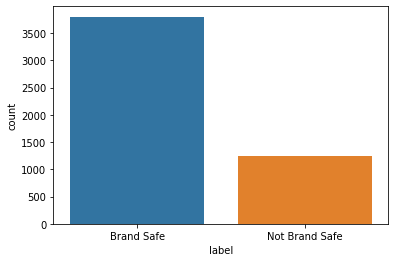

In [ ]:
sns.countplot(df.label)
plt.xlabel('label');

In [ ]:
df[df['label']=="Brand Safe"].sample(10)

,title,content,label
1003,Το «Grandma’s» είναι το γαστρονομικό must της Ίου,ΔοκιμάσαμεΤο «Grandma’s» είναι το γαστρονομικό...,Brand Safe
594,Πληθαίνει ο αριθμός των ανθρώπων κατά των Ολυμ...,Πληθαίνει ανησυχητικά ο αριθμός των ανθρώπων π...,Brand Safe
461,Η κόρη του πασίγνωστου ζευγαριού μεγάλωσε πολύ...,Η Ava Philippe έκλεισε τα 18 και πλέον είναι μ...,Brand Safe
3018,"Εγώ, η Τόνια","ΚριτικήΕγώ, η Τόνια0Δραματική βιογραφία στημέν...",Brand Safe
3091,Κινηµατογραφιστές ενωµένοι εν δράσει,Συνάντηση µε την υπουργό Πολιτισµού Μυρσίνη Ζο...,Brand Safe
1258,Κοτόπουλο σκεπαστό με τραγανή ζύμη,ΥΛΙΚΑ\n\nΓια τη ζύμη:\n\n250 γρ αλεύρι που φου...,Brand Safe
2627,Ζητήματα Φωτός: Έκθεση του Γεράσιμου Κανάκη στ...,Θα παρουσιαστούν 25 έργα μεσαίων και μεγάλων δ...,Brand Safe
1569,Επαναλαμβάνονται αύριο οι εκλογές στο εκλογικό...,Επαναλάμβάνονται αύριο οι εκλογές στο 33ο εκλο...,Brand Safe
2240,Όλα τριγύρω αλλάζουν κι όλο τα ίδια μένουν,"Πέμπτη, 16 Οκτώβριος 2014\n\nΠρόσφατη έρευνα π...",Brand Safe
354,Δείτε πως είναι σήμερα η «Ντένη Μαρκορά» από τ...,Όλοι την αγαπήσαμε και τη θυμόμαστε ως Ντένη Μ...,Brand Safe


In [ ]:
df[df['label']=="Not Brand Safe"].sample(10)

,title,content,label
4226,Όσκαρ Πιστόριους: αυτές είναι οι σοκαριστικές ...,Ποιες οι εξελίξεις στη δίκη του Όσκαρ Πιστόριο...,Not Brand Safe
4231,"Σοκ με αποκαλύψεις για επιχειρηματία-14χρονη, ...",Ποιες οι αποκαλύψεις για τον επιχειρηματία και...,Not Brand Safe
4497,Η απολαυστική Σοφία Χαρμαντά [ΦΩΤΟ],Θραύση στον ανδρικό πληθυσμό κάνει η Σοφία Χαρ...,Not Brand Safe
4876,Νέα στοιχεία για την τραγωδία στη Μεσσήνη: Ψυχ...,"Ο 59χρονος άνεργος, που φέρεται να σκότωσε τη ...",Not Brand Safe
3951,Πάτρα: Κρατούμενος κατάπιε 45 συσκευασίες με χ...,"Ειδικότερα, σύμφωνα με την Αστυνομία, άνδρες τ...",Not Brand Safe
4411,Η Sammy με τα ζουμερά και μεγάλα βυζιά της έξω...,Η Sammy Braddy θα είναι για πάντα μία από τις ...,Not Brand Safe
4856,Βασίλης Λυριτζής: Αυτή ήταν η τελευταία του επ...,Ο Βασίλης Λυριτζής «έφυγε» από τη ζωή τα ξημερ...,Not Brand Safe
3884,Συνελήφθησαν στην Εθνικό Οδό να μεταφέρουν 99 ...,Συνελήφθησαν τα ξημερώματα στην εθνική οδό ενώ...,Not Brand Safe
5031,Γιάννενα: Ανακοίνωση της Δημοτικής Αρχής για τ...,Ανακοίνωση για την αυτοκτονία του Νίκου Μάντη ...,Not Brand Safe
4748,Ναγκόρνο - Καραμπάχ: Η σύγκρουση στα βορειότερ...,"Η πόλη Martakert του Ναγκόρνο - Καραμπάχ, στα ...",Not Brand Safe


In [5]:
# define the function to strip accents and lowercase
def strip_accents_and_lowercase(s):
   return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn').lower()

In [6]:
# define the function to remove punctuation
def remove_punctuation(text):
    text = text.strip('\n')
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree

In [ ]:
# import greek bert model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("nlpaueb/bert-base-greek-uncased-v1", truncation=True)
Bert_model = AutoModel.from_pretrained("nlpaueb/bert-base-greek-uncased-v1", return_dict=False)

In [ ]:
token_lens_title = [len(tokenizer.encode(txt, add_special_tokens=False)) for txt in df.title]
token_title_safe = [len(tokenizer.encode(txt, add_special_tokens=False)) for txt in df[df['label']=='Brand Safe']['title']]
token_title_not_safe = [len(tokenizer.encode(txt, add_special_tokens=False)) for txt in df[df['label']=='Not Brand Safe']['title']]

token_lens_content = [len(tokenizer.encode(txt, max_length=512, add_special_tokens=False)) for txt in df.content]
token_content_safe = [len(tokenizer.encode(txt, max_length=512, add_special_tokens=False)) for txt in df[df['label']=='Brand Safe']['content']]
token_content_not_safe = [len(tokenizer.encode(txt, max_length=512, add_special_tokens=False)) for txt in df[df['label']=='Not Brand Safe']['content']]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


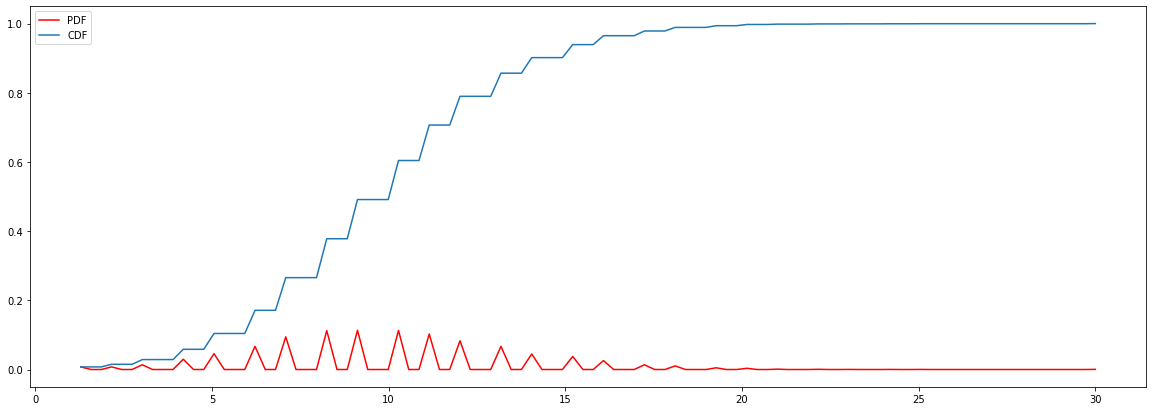

In [ ]:
# examine the distribution of title lengths using PDF and CDF 
plt.rcParams["figure.figsize"] = (20,7)

fig, ax = plt.subplots()
count, bins_count = np.histogram([len(title.split()) for title in df['title']], bins=100)
  
# finding the PDF of the histogram using count values
pdf = count / sum(count)

cdf = np.cumsum(pdf)
# plotting PDF and CDF
plt.plot(bins_count[1:], pdf, color="red", label="PDF")
plt.plot(bins_count[1:], cdf, label="CDF")

plt.legend()

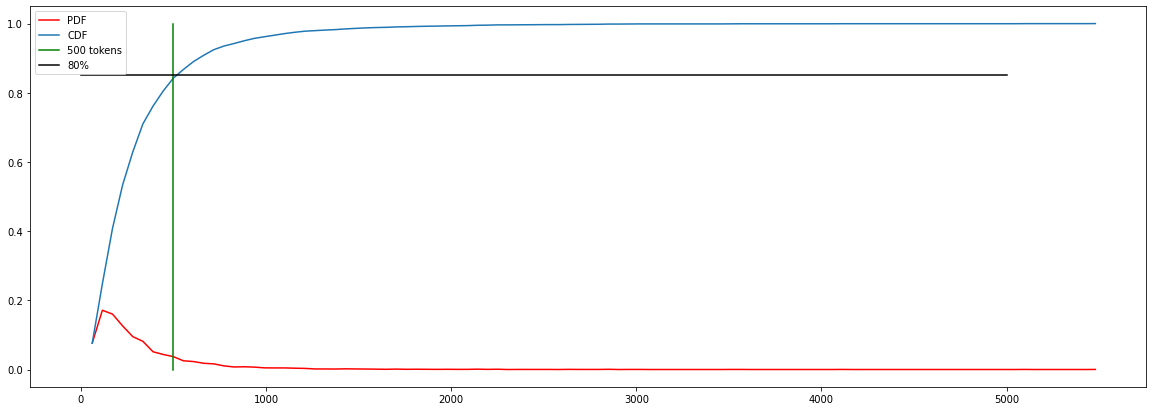

In [ ]:
# examine the distribution of content lengths using PDF and CDF 

fig, ax = plt.subplots()
count, bins_count = np.histogram([len(content.split()) for content in df['content']], bins=100)
  
# finding the PDF of the histogram using count values
pdf = count / sum(count)
  
cdf = np.cumsum(pdf)
plt.plot(bins_count[1:], pdf, color="red", label="PDF")
plt.plot(bins_count[1:], cdf, label="CDF")
plt.plot([500, 500], [0, 1], label="500 tokens", color='green')
plt.plot([0, 5000], [0.85, 0.85], label="80%", color='black')
plt.legend()

We see that almost 85% of the contents have a size of at most 500 tokens (albeit with a naive tokenization). Therefore the information loss by truncating the larger texts to the max_size of 512 of the greek bert model (as demonstrated in their [model card](https://huggingface.co/nlpaueb/bert-base-greek-uncased-v1)) is acceptable for this assignment.

In [ ]:
df[df['label']=='Brand Safe']['title']

0               Κάθε πότε πρέπει να λούζεις τα μαλλιά σου
1       Τα 5 χειρότερα λάθη που κάνεις με το gel μαλλιών!
2       Οι 6 κλασικοί άντρες που συχνάζουν σε ένα μπαρ...
3       Βρες ποιο μούσι σου ταιριάζει ανάλογα με το σχ...
4       Δεν ξέρουμε πώς να νιώσουμε για τον ξυρισμένο ...
                              ...                        
3795    Πολάκης: Παράταση της θητείας των επικουρικών ...
3796       Ολιγάμνιο: Όταν το μωρό έχει λίγο αμνιακό υγρό
3797    «Χρυσός» οδηγός για διακοπές: Αυτά τα φάρμακα ...
3798     Ντους μετά το φαγητό: Είναι πράγματι επικίνδυνο;
3799    Τι συμβαίνει την επόμενη μέρα αν πάτε για ύπνο...
Name: title, Length: 3800, dtype: object

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

Text(0.5, 0, 'Not safe')

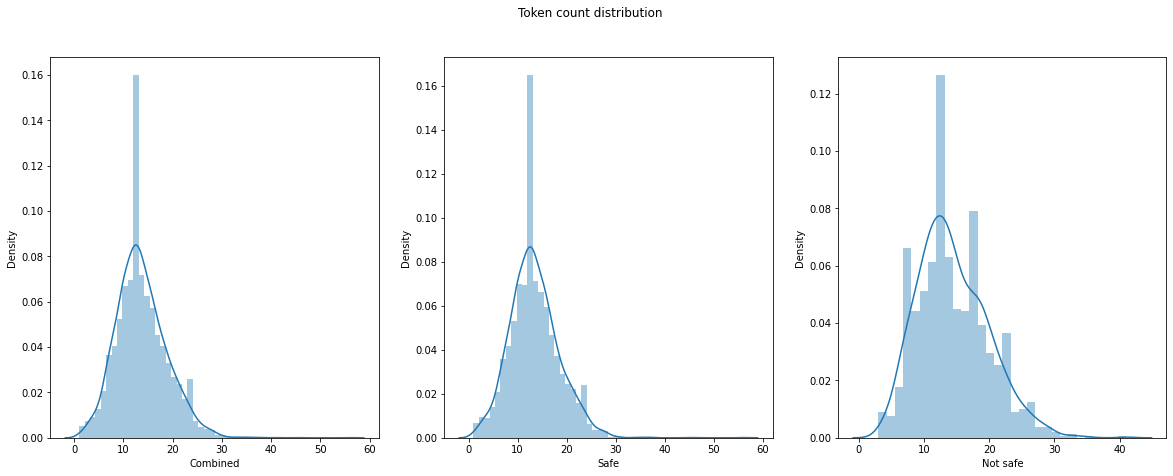

In [ ]:
fig, axs = plt.subplots(ncols=3)
sns.distplot(token_lens_title, ax=axs[0])
axs[0].set_xlabel('Combined')
fig.suptitle('Token count distribution')

sns.distplot(token_title_safe, ax=axs[1])
axs[1].set_xlabel("Safe")
sns.distplot(token_title_not_safe, ax=axs[2])
axs[2].set_xlabel("Not safe")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

Text(0.5, 0, 'Not safe')

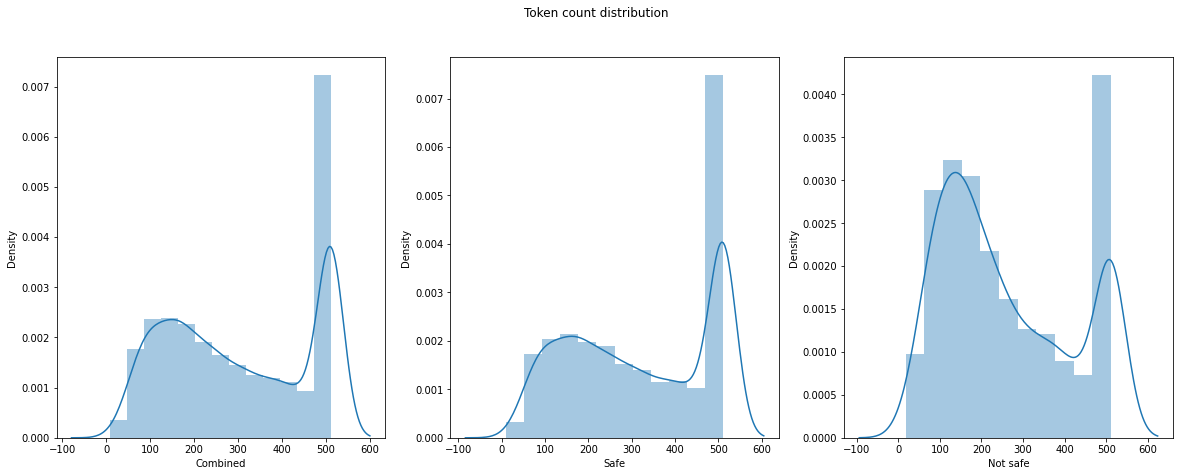

In [ ]:
fig, axs = plt.subplots(ncols=3)
sns.distplot(token_lens_content, ax=axs[0])
axs[0].set_xlabel('Combined')
fig.suptitle('Token count distribution')

sns.distplot(token_content_safe, ax=axs[1])
axs[1].set_xlabel("Safe")
sns.distplot(token_content_not_safe, ax=axs[2])
axs[2].set_xlabel("Not safe")

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [8]:
# text preprocessing by apllying the functions

df['title'] = df['title'].apply(lambda x: strip_accents_and_lowercase(x.replace('\n', ' ')))
df['content'] = df['content'].apply(lambda x: strip_accents_and_lowercase(x.replace('\n', ' ')))
df.head()

,title,content,label
0,καθε ποτε πρεπει να λουζεις τα μαλλια σου,share on whatsapp η καθαριοτητα ειναι η μιση ...,Brand Safe
1,τα 5 χειροτερα λαθη που κανεις με το gel μαλλιων!,το gel μαλλιων ειναι απο τα αγαπημενα προιοντα...,Brand Safe
2,οι 6 κλασικοι αντρες που συχναζουν σε ενα μπαρ...,grooming | 09/12/2019 οι 6 κλασικ...,Brand Safe
3,βρες ποιο μουσι σου ταιριαζει αναλογα με το σχ...,χρονο με το χρονο ολο και περισσοτεροι αντρες ...,Brand Safe
4,δεν ξερουμε πως να νιωσουμε για τον ξυρισμενο ...,"δεν θυμαμαι που το ειχα διαβασει, αλλα καποιος...",Brand Safe


In [33]:
# define function wich removes stopwords and forms the articles into a whole string 

def clean_text(df_column):
  text = [word for word in df_column]
  tokens_without_sw = [word.replace('ς', 'σ') for word in text if not word in stopwords]
  text_final = " ".join(word for word in tokens_without_sw)
  return text_final

In [34]:
# we collect the whole texts to create wordclouds
# 0 index corrsponds to 'Brand Safe' content and 1 index to 'Not Brand Safe'

title_0 = clean_text(df[df['label']=='Brand Safe']['title'])
title_1 = clean_text(df[df['label']=='Not Brand Safe']['title'])
content_0 = clean_text(df[df['label']=='Brand Safe']['content'])
content_1 = clean_text(df[df['label']=='Not Brand Safe']['content'])

**Wordclouds for titles and content and for each label**

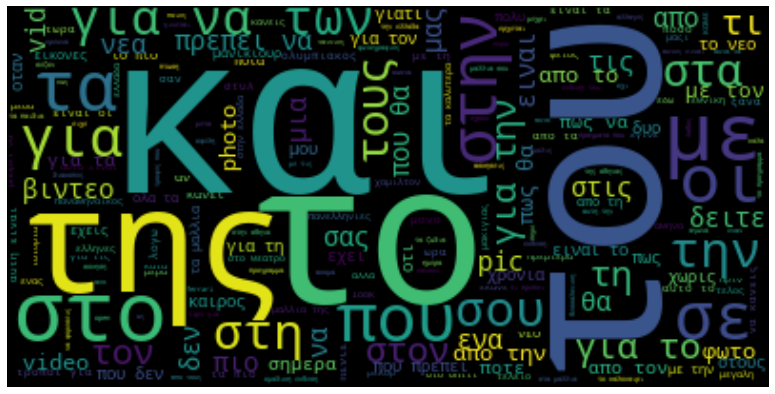

In [ ]:
wordcloud = WordCloud().generate(title_0)
# wordcloud_1 = WordCloud().generate(text_1)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
# plt.imshow(wordcloud_1, interpolation='bilinear')
plt.axis("off")
plt.show()

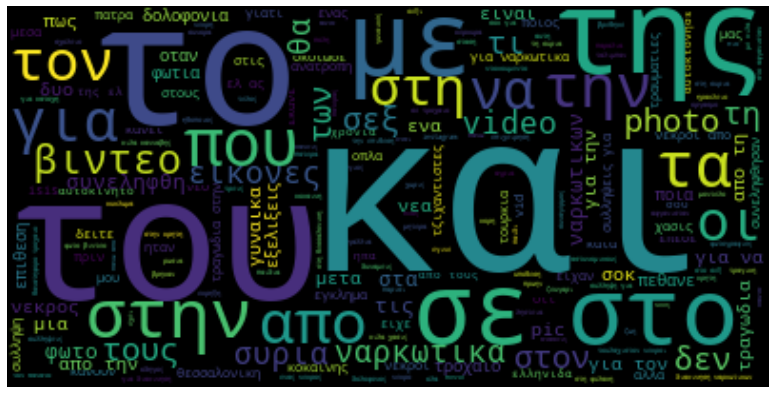

In [ ]:
wordcloud = WordCloud().generate(title_1)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

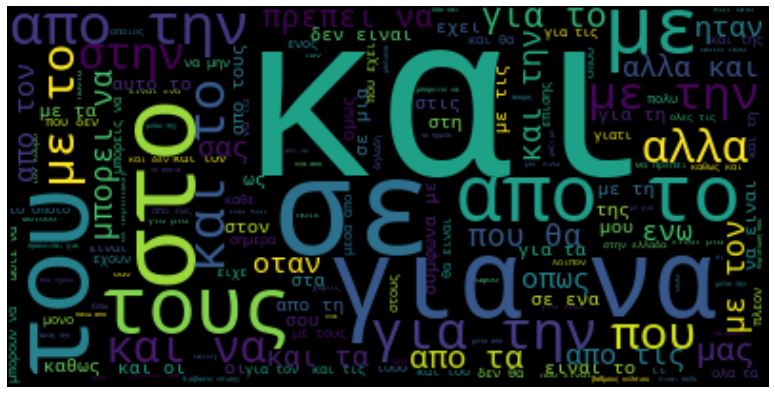

In [ ]:
wordcloud = WordCloud().generate(content_0)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

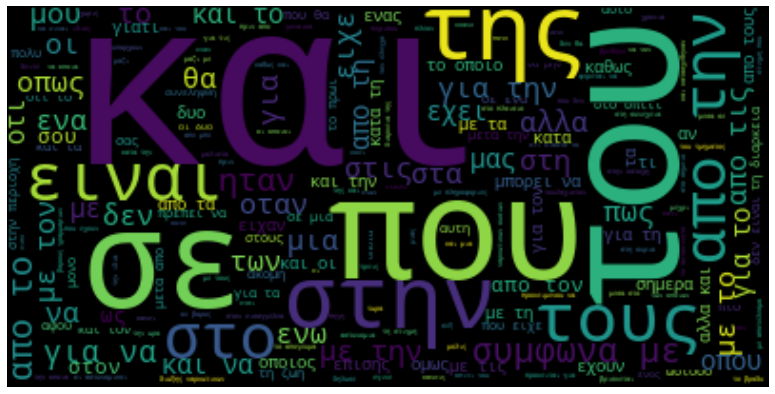

In [ ]:
wordcloud = WordCloud().generate(content_1)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

We can see that **'Not Brand Safe' title - wordcloud** contains very specific words compared to other wordclouds.

## 1. Train a classifier on this dataset that will reach an acceptable accuracy score.

#### Feel free to follow any design choices you feel fit the problem best.

#### Briefly describe your approach in markdown cells, along with any necessary comments on your choices.

#### Explain your choices with the appropriate evaluation plots - analysis

In [ ]:
MAX_LEN = 512

We choose Bert for our classifier.

We create the dataset loader using the content of the articles as the main input.

In [ ]:
class ArticleDataset(Dataset):
  def __init__(self, content, targets, tokenizer, max_len):
    self.content = content
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.content)
  def __getitem__(self, item):
    content = str(self.content[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      content,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
  
    return {
      'text': content,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
brand = {'Brand Safe' : 0, 'Not Brand Safe' : 1}
df.label = [brand[item] for item in df.label]

In [ ]:
df_train, df_val = train_test_split(
  df[['content','label']],
  test_size=0.1,
  random_state=RANDOM_SEED
)

df_train.shape, df_val.shape

((4545, 2), (505, 2))

In [ ]:
df.head()

,title,content,label
0,καθε ποτε πρεπει να λουζεις τα μαλλια σου,share on whatsapp η καθαριοτητα ειναι η μιση ...,0
1,τα 5 χειροτερα λαθη που κανεις με το gel μαλλιων!,το gel μαλλιων ειναι απο τα αγαπημενα προιοντα...,0
2,οι 6 κλασικοι αντρες που συχναζουν σε ενα μπαρ...,grooming | 09/12/2019 οι 6 κλασικ...,0
3,βρες ποιο μουσι σου ταιριαζει αναλογα με το σχ...,χρονο με το χρονο ολο και περισσοτεροι αντρες ...,0
4,δεν ξερουμε πως να νιωσουμε για τον ξυρισμενο ...,"δεν θυμαμαι που το ειχα διαβασει, αλλα καποιος...",0


Data loader creation

In [ ]:
MAX_LEN =512

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = ArticleDataset(
    # title=df.title.to_numpy(),
    content=df.content.to_numpy(),
    targets=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )
BATCH_SIZE = 4
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


We define the classifier using Bert model and dorpout of 0.2

In [ ]:
class ArticleClassifier(nn.Module):
  def __init__(self, n_classes):
    super(ArticleClassifier, self).__init__()
    self.bert = Bert_model
    self.drop = nn.Dropout(p=0.2)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
class_names = list(df.label.unique())
model = ArticleClassifier(len(class_names))
model = model.to(device)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([4, 512])
torch.Size([4, 512])


In [ ]:
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()  
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
# model = torch.load('/content/drive/MyDrive/best_model_state.bin')

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), '/content/drive/MyDrive/best_model_state.bin')
    best_accuracy = val_acc

In [ ]:
train_acc = torch.tensor(history['train_acc'], device = 'cpu')
val_acc = torch.tensor(history['val_acc'], device = 'cpu')

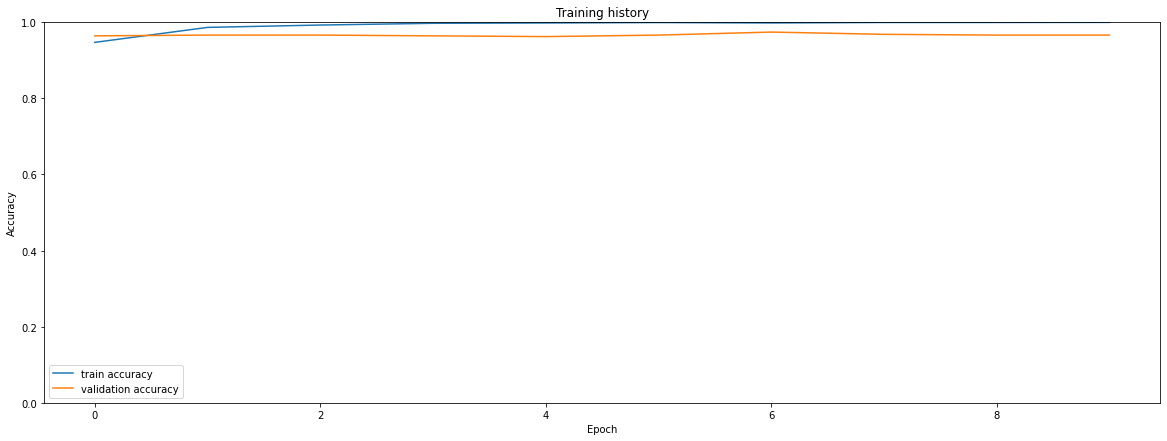

In [ ]:
plt.plot(train_acc, label='train accuracy')
plt.plot(val_acc, label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

## 2. Load a real-world, unseen (test) dataset and evaluate your best model

### The goal is to approach the classification accuracy of the train dataset on the test dataset, without using the latter for training. Describe any challenges (if they exist) and code your solution below following the same guidelines 

In [ ]:
df_unseen = pd.read_csv('/content/drive/MyDrive/assignment/assignment_unseen.csv')
df_unseen.head()

,url,title,content,label
0,https://www.ratpack.gr/manual/travel/story/230...,Τέσσερις ελληνικές παραλίες που δεν θα φύγουν ...,Τέσσερις ελληνικές παραλίες που δεν θα φύγουν ...,Brand Safe
1,https://www.gossip-tv.gr/showbiz/story/699353/...,Καραβάτου: Η πρώτη ανάρτηση μετά την ανακοίνωσ...,Ο Κρατερός Κατσούλης και η Κατερίνα Καραβάτου ...,Brand Safe
2,https://www.news247.gr/kairos/exasthenisi-toy-...,Εξασθένηση του μελτεμιού και θερμόμετρο στους ...,Η θερμοκρασία θα παρουσιάσει μικρή άνοδο και τ...,Brand Safe
3,https://www.iefimerida.gr/politiki/hatzidakis-...,Χατζηδάκης για ασφαλιστικό: Οι νέοι θέλουν νέα...,«Οι νέοι άνθρωποι θέλουν νέα πράγματα. Δεν του...,Brand Safe
4,https://www.iefimerida.gr/news/355693/i-champi...,Η Championship Αγγλίας αποκλειστικά στη Nova!,Πρεμιέρα στις μεταδόσεις το Σάββατο 12/8 με το...,Brand Safe


We apply the same preprocessing function to the unseen data

In [ ]:
df_unseen['title'] = df_unseen['title'].apply(lambda x: strip_accents_and_lowercase(x.strip('\n')))
df_unseen['content'] = df_unseen['content'].apply(lambda x: strip_accents_and_lowercase(x.strip('\n')))
df_unseen['title'] = df_unseen['title'].apply(lambda x:remove_punctuation(x))
df_unseen['content'] = df_unseen['content'].apply(lambda x:remove_punctuation(x))
brand = {'Brand Safe' : 0, 'Not Brand Safe' : 1}
df_unseen.label = [brand[item] for item in df_unseen.label]
df_unseen.head()

,url,title,content,label
0,https://www.ratpack.gr/manual/travel/story/230...,τεσσερις ελληνικες παραλιες που δεν θα φυγουν ...,τεσσερις ελληνικες παραλιες που δεν θα φυγουν ...,0
1,https://www.gossip-tv.gr/showbiz/story/699353/...,καραβατου η πρωτη αναρτηση μετα την ανακοινωση...,ο κρατερος κατσουλης και η κατερινα καραβατου ...,0
2,https://www.news247.gr/kairos/exasthenisi-toy-...,εξασθενηση του μελτεμιου και θερμομετρο στους ...,η θερμοκρασια θα παρουσιασει μικρη ανοδο και τ...,0
3,https://www.iefimerida.gr/politiki/hatzidakis-...,χατζηδακης για ασφαλιστικο οι νεοι θελουν νεα ...,«οι νεοι ανθρωποι θελουν νεα πραγματα δεν τους...,0
4,https://www.iefimerida.gr/news/355693/i-champi...,η championship αγγλιας αποκλειστικα στη nova,πρεμιερα στις μεταδοσεις το σαββατο 128 με του...,0


In [ ]:
test_data_loader = create_data_loader(df_unseen, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data_unseen = next(iter(test_data_loader))
data.keys()

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_unseen)
)
test_acc.item()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

0.7861538461538462

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  content_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      content_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return content_texts, predictions, prediction_probs, real_values

In [ ]:
y_content_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=['Brand Safe', 'Not Brand Safe']))

                precision    recall  f1-score   support

    Brand Safe       0.52      1.00      0.68       150
Not Brand Safe       1.00      0.72      0.84       500

      accuracy                           0.79       650
     macro avg       0.76      0.86      0.76       650
  weighted avg       0.89      0.79      0.80       650



## 3a. Another important task is to perform topic classification on the same datasets, but there are no available labels. You can use the entirety of data you have at your disposal. Describe possible approaches to this problem and code the most robust solution of your choice. 

We will use the LDA model for text clustering.

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words_title = list(sent_to_words(df.title))
data_words_content = list(sent_to_words(df.content))
data_words = list([title + content for title, content in zip(data_words_title, data_words_content)])
print(data_words[:1])

[['καθε', 'ποτε', 'πρεπει', 'να', 'λουζεις', 'τα', 'μαλλια', 'σου', 'share', 'on', 'whatsapp', 'καθαριοτητα', 'ειναι', 'μιση', 'αρχοντια', 'και', 'τα', 'μαλλια', 'σου', 'ειναι', 'ενα', 'απ', 'αυτα', 'που', 'φανερωνουν', 'πολλα', 'για', 'την', 'υγιεινη', 'σου', 'ποσο', 'συχνα', 'πρεπει', 'να', 'λουζεσαι', 'ωστε', 'να', 'εισαι', 'καθαρος', 'αλλα', 'να', 'μην', 'προκαλεσεις', 'ζημια', 'στα', 'μαλλια', 'σου', 'το', 'πολυ', 'συχνο', 'λουσιμο', 'εχει', 'ως', 'συνεπεια', 'την', 'απωλεια', 'φυσικων', 'θρεπτικων', 'συστατικων', 'κι', 'αν', 'ανηκεις', 'σε', 'αυτους', 'που', 'ξεχνουν', 'καθε', 'ποτε', 'χρησιμοποιουν', 'σαμπουαν', 'κινδυνευεις', 'να', 'δειχνεις', 'σαν', 'να', 'εχεις', 'μαλλι', 'τζιβα', 'παρολο', 'που', 'καμια', 'σχεση', 'δεν', 'ειχες', 'εχεις', 'θα', 'εχεις', 'ποτε', 'με', 'την', 'καθολα', 'συμπαθητικη', 'ρασταφαριαν', 'κοινοτητα', 'ποια', 'ειναι', 'λοιπον', 'ιδανικη', 'συχνοτητα', 'οι', 'περισσοτεροι', 'ειδικοι', 'προτεινουν', 'δυο', 'φορες', 'την', 'εβδομαδα', 'βεβαια', 'κατι', 

In [ ]:
# create bigrams and trigrams for title texts

bigram = gensim.models.Phrases(data_words_title, min_count=5, threshold=100) 
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

print(trigram_mod[bigram_mod[data_words[0]]])

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['καθε', 'ποτε', 'πρεπει', 'να', 'λουζεις', 'τα', 'μαλλια', 'σου', 'share_on', 'whatsapp', 'καθαριοτητα', 'ειναι', 'μιση', 'αρχοντια', 'και', 'τα', 'μαλλια', 'σου', 'ειναι', 'ενα', 'απ', 'αυτα', 'που', 'φανερωνουν', 'πολλα', 'για', 'την', 'υγιεινη', 'σου', 'ποσο', 'συχνα', 'πρεπει', 'να', 'λουζεσαι', 'ωστε', 'να', 'εισαι', 'καθαρος', 'αλλα', 'να', 'μην', 'προκαλεσεις', 'ζημια', 'στα', 'μαλλια', 'σου', 'το', 'πολυ', 'συχνο', 'λουσιμο', 'εχει', 'ως', 'συνεπεια', 'την', 'απωλεια', 'φυσικων', 'θρεπτικων_συστατικων', 'κι', 'αν', 'ανηκεις', 'σε', 'αυτους', 'που', 'ξεχνουν', 'καθε', 'ποτε', 'χρησιμοποιουν', 'σαμπουαν', 'κινδυνευεις', 'να', 'δειχνεις', 'σαν', 'να', 'εχεις', 'μαλλι', 'τζιβα', 'παρολο', 'που', 'καμια_σχεση', 'δεν', 'ειχες', 'εχεις', 'θα', 'εχεις', 'ποτε', 'με', 'την', 'καθολα', 'συμπαθητικη', 'ρασταφαριαν', 'κοινοτητα', 'ποια', 'ειναι', 'λοιπον', 'ιδανικη', 'συχνοτητα', 'οι', 'περισσοτεροι', 'ειδικοι', 'προτεινουν', 'δυο', 'φορες', 'την', 'εβδομαδα', 'βεβαια', 'κατι_τετοιο', 'εχ

In [ ]:

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stopwords] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

First we classify the articles based explicitly on their title.

In [ ]:
data_words_nostops = remove_stopwords(data_words_title)

# form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

nlp = spacy.load('el_core_news_md', disable=['parser', 'ner'])

# lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['καθε', 'ποτε', 'πρεπω', 'λουζει', 'μαλλιας']]


In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]]


In [ ]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('καθε', 1), ('λουζει', 1), ('μαλλιας', 1), ('ποτε', 1), ('πρεπω', 1)]]

We define a function to choose the best lda model, through the number of topics.
we start from 2 topics and increase them by 3.

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        # model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(lda_model)
        coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=3)

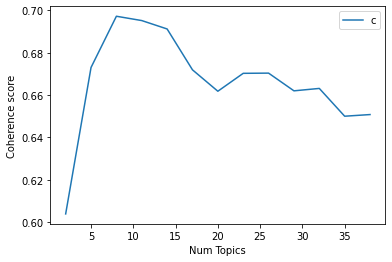

In [ ]:
# coherence scores

limit=40; start=2; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
for m in model_list:
  print(m)

LdaModel(num_terms=8133, num_topics=2, decay=0.5, chunksize=100)
LdaModel(num_terms=8133, num_topics=5, decay=0.5, chunksize=100)
LdaModel(num_terms=8133, num_topics=8, decay=0.5, chunksize=100)
LdaModel(num_terms=8133, num_topics=11, decay=0.5, chunksize=100)
LdaModel(num_terms=8133, num_topics=14, decay=0.5, chunksize=100)
LdaModel(num_terms=8133, num_topics=17, decay=0.5, chunksize=100)
LdaModel(num_terms=8133, num_topics=20, decay=0.5, chunksize=100)
LdaModel(num_terms=8133, num_topics=23, decay=0.5, chunksize=100)
LdaModel(num_terms=8133, num_topics=26, decay=0.5, chunksize=100)
LdaModel(num_terms=8133, num_topics=29, decay=0.5, chunksize=100)
LdaModel(num_terms=8133, num_topics=32, decay=0.5, chunksize=100)
LdaModel(num_terms=8133, num_topics=35, decay=0.5, chunksize=100)
LdaModel(num_terms=8133, num_topics=38, decay=0.5, chunksize=100)


In [ ]:
print(model_list[2].print_topics())
doc_lda = model_list[2][corpus]

[(0, '0.036*"πεθανε" + 0.025*"κανω" + 0.015*"πολη" + 0.011*"πρεπω" + 0.010*"πηγε" + 0.010*"ετσι" + 0.010*"στρα" + 0.009*"ηρακλειος" + 0.009*"ατυχημας" + 0.008*"εκρηξη"'), (1, '0.054*"συριος" + 0.034*"επιθεση" + 0.024*"βρεθηκε" + 0.021*"εχω" + 0.017*"μετα" + 0.014*"τραγωδιας" + 0.014*"ασφαλτος" + 0.007*"αυτη" + 0.007*"αυτος" + 0.007*"σκοτωθηκαν"'), (2, '0.096*"νεκρος" + 0.039*"τραγωδιος" + 0.024*"θανατο" + 0.023*"φωτι" + 0.016*"ελλαδας" + 0.014*"ναρκωτικα" + 0.011*"εξελιξει" + 0.010*"σημερα" + 0.009*"εγινε" + 0.008*"ηπας"'), (3, '0.042*"νεος" + 0.022*"ζωη" + 0.019*"ναρκωτικας" + 0.014*"συλληψει" + 0.012*"κοσμο" + 0.011*"ελικοπτερο" + 0.011*"γαλλιας" + 0.011*"στοιχει" + 0.010*"οπλο" + 0.009*"σπιτιο"'), (4, '0.086*"βιντεο" + 0.023*"δειτε" + 0.015*"ατυχημας" + 0.015*"τραυματιε" + 0.009*"τελευταια" + 0.009*"φοιτητη" + 0.008*"ποτε" + 0.008*"στρατο" + 0.008*"γνωστος" + 0.008*"ανατροπη"'), (5, '0.027*"χρονη" + 0.015*"σπιτι" + 0.014*"δολοφονιο" + 0.014*"γυναικα" + 0.014*"μεσα" + 0.011*"τζιχαντι

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', model_list[2].log_perplexity(corpus))

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=model_list[2], texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -10.580891675986953

Coherence Score:  0.6972126493592744


In [ ]:
# Visualize the 14-topic model
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(model_list[4], corpus, id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10     0.345218 -0.118629       1        1  13.245812
9      0.093368  0.346795       2        1   8.103293
11    -0.026707 -0.001529       3        1   7.186863
7     -0.010019 -0.023163       4        1   7.087129
6     -0.042354 -0.024783       5        1   7.063645
3     -0.040429 -0.018784       6        1   6.773416
8     -0.044420 -0.025397       7        1   6.738585
13    -0.047565 -0.017959       8        1   6.490147
1     -0.037306 -0.016396       9        1   6.405522
2     -0.037451 -0.003987      10        1   6.396062
0     -0.039969 -0.023153      11        1   6.252457
12    -0.050927 -0.030411      12        1   6.138543
4     -0.025434 -0.024611      13        1   6.089876
5     -0.036003 -0.017993      14        1   6.028652, topic_info=            Term        Freq       Total Category  logprob  loglift
537       βιντεο  205.000000  205.000000  Default  30.0000  30.0000
1691      νεκρος  215.000000  215.000000  Default  29.0000  29.0000
502        χρονο  268.000000  268.000000  Default  28.0000  28.0000
7516      συριος  133.000000  133.000000  Default  27.0000  27.0000
259         νεος  120.000000  120.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
5219  αεροσκαφου    5.882004    6.520797  Topic14  -5.4245   2.7055
8094  καθηγητριο    7.715592    8.555123  Topic14  -5.1531   2.7054
8102     ζωντανο    7.652407    8.531528  Topic14  -5.1613   2.6999
7624       λιβυη    9.013016   10.135130  Topic14  -4.9977   2.6913
8093   χτυπηματο    7.578606    8.477078  Topic14  -5.1710   2.6966

[480 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1617      5  0.951580   ferrari
1204      6  0.951021     αγαπη
468       1  0.944738     αγιος
5774     10  0.929456  αγνωστος
3070     10  0.988706    αγορας
...     ...       ...       ...
6131     11  0.889090     χωριο
83        5  0.965136     χωρις
7478      3  0.944797      ψαρα
841       7  0.925117     ψαχνω
1097      5  0.949838       ωρο

[458 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 10, 12, 8, 7, 4, 9, 14, 2, 3, 1, 13, 5, 6])

In [ ]:
# Visualize the 8-topic model
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(model_list[3], corpus, id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.351505  0.014750       1        1  15.266736
3      0.050436  0.328880       2        1   9.372262
0      0.009935 -0.036301       3        1   9.326701
9      0.035792 -0.048270       4        1   8.849099
7      0.044413 -0.021126       5        1   8.694193
1      0.045054 -0.054850       6        1   8.677676
6      0.023421 -0.045851       7        1   8.124772
8      0.040435 -0.009465       8        1   8.095772
10     0.045356 -0.048344       9        1   8.046221
2      0.027666 -0.035865      10        1   7.811991
4      0.028999 -0.043557      11        1   7.734577, topic_info=               Term        Freq       Total Category  logprob  loglift
537          βιντεο  212.000000  212.000000  Default  30.0000  30.0000
1691         νεκρος  215.000000  215.000000  Default  29.0000  29.0000
502           χρονο  233.000000  233.000000  Default  28.0000  28.0000
4261            σεξ  126.000000  126.000000  Default  27.0000  27.0000
259            νεος  117.000000  117.000000  Default  26.0000  26.0000
...             ...         ...         ...      ...      ...      ...
8102        ζωντανο    8.680570   10.021542  Topic11  -5.2844   2.4158
8131     αεροπλανας    8.262016   10.005226  Topic11  -5.3339   2.3680
8132  ανεμοστροβιλο    8.262016   10.005226  Topic11  -5.3339   2.3680
7528      ισλαμικος   11.211209   25.765005  Topic11  -5.0286   1.7274
7587       επιθεσει    8.016058   10.993099  Topic11  -5.3641   2.2436

[386 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
5774     10  0.961428    αγνωστος
3070      2  0.932301      αγορας
4614      2  0.930223      αγριος
2541      8  0.935938       αερας
472       9  0.962358  αεροδρομιο
...     ...       ...         ...
1480     10  0.952820    χτυπησαν
7139     10  0.977732     χτυπησε
6131      5  0.917854       χωριο
83        3  0.969446       χωρις
1097      7  0.934705         ωρο

[370 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 4, 1, 10, 8, 2, 7, 9, 11, 3, 5])

The iteration through the LDA model shows that the model with the highest coherence is the 8-topic LDA. Six of the clusters are clearly overlapped, meaning that they may form a distinct cluster. 3-topic LDA produces the exact clusters wihout any overlapping.

In [ ]:
# Repeat the process but for a 3-topic LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.037*"νεκρος" + 0.029*"βιντεο" + 0.010*"πεθανε" + 0.009*"σοκ" + 0.009*"φωτι" + 0.009*"βρεθηκε" + 0.008*"κανω" + 0.007*"ζωη" + 0.007*"τροχαιο" + 0.006*"συριος"'), (1, '0.015*"νεος" + 0.013*"επιθεση" + 0.010*"συριος" + 0.009*"χρονη" + 0.008*"εχω" + 0.008*"δειτε" + 0.007*"τροχαιο" + 0.007*"μετα" + 0.004*"παραλιας" + 0.004*"θελω"'), (2, '0.032*"χρονο" + 0.018*"εικονε" + 0.014*"σεξ" + 0.009*"θανατο" + 0.008*"τραγωδιος" + 0.008*"τροχαιο" + 0.007*"τωρα" + 0.007*"ειχε" + 0.007*"θεσσαλονικη" + 0.006*"επεσε"')]


In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.81162994820267

Coherence Score:  0.6497117996183502


In [ ]:
# Visualize the 3-topic model
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.074942  0.054166       1        1  33.848728
1      0.018592 -0.081388       2        1  33.476041
2     -0.093534  0.027222       3        1  32.675231, topic_info=           Term        Freq       Total Category  logprob  loglift
1691     νεκρος  283.000000  283.000000  Default  30.0000  30.0000
502       χρονο  233.000000  233.000000  Default  29.0000  29.0000
537      βιντεο  218.000000  218.000000  Default  28.0000  28.0000
504      εικονε  129.000000  129.000000  Default  27.0000  27.0000
259        νεος  110.000000  110.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
1411  τελευταια   21.382752   23.506165   Topic3  -5.8239   1.0239
7160  τραγωδιος   60.585900  113.234510   Topic3  -4.7824   0.4932
1462    τροχαιο   56.971539  157.993105   Topic3  -4.8439   0.0986
4915  τραυματιε   24.235193   37.842317   Topic3  -5.6986   0.6729
7516     συριος   34.649420  149.761020   Topic3  -5.3412  -0.3452

[157 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1204      1  0.979378   αγαπη
468       1  0.957293   αγιος
384       2  0.994491   αθηνο
357       1  0.041645  αθηνος
357       2  0.041645  αθηνος
...     ...       ...     ...
502       1  0.004290   χρονο
502       2  0.004290   χρονο
502       3  0.995261   χρονο
83        1  0.980085   χωρις
1097      3  0.970030     ωρο

[211 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

## 3b. Supposing these are last week's news and we wish to extract the latest circulating trends in order to present them to our clients, how could we approach the problem of trend extraction via NLP? Either code or describe on a high-level the best possible approach that comes to mind. (This question may be connected to the previous one depending on your solution, which is acceptable).

##### Hint: Proper text preprocessing may assist in this task, if not done already.

Answer 3b. LDA model describes different categories from latest news. Clusters are distinct between them and they have a large size. Meaning that news titles in each cluster are greatly connected contextually.
In order to extract the latest trend, we can preprocess our data. like removing the stopwords and apply lemmatization. Selecting the most frequent words in each cluster and search for them in our data, can give us the latest news trends.

## 4. (Optional) Discussion. Feel free to answer some or all of the following questions to the best of your knowledge.

#### Coding is optional and not expected below, except for the case you wish to accompany your answer with example code.

#### 4a. Suppose there is a complete labeled topic classification dataset available (hundreds of thousands of articles). Are there any changes in your design choices that would lead to a more accurate model?

Answer 4a. Another and more efficient approach would be a document or sentence representation, instead of word or subword representation, since the articles have a very large length.
Transformers include a limited token length and regarding our classifier the 85% of input texts are up to the allowed length.
Proper text preprocessing and Bag of Words combined with another classifier, such as SVM or Logistic Regression would be another choice.

#### 4b. In order to meet production requirements, the model needs to have as close to 20 ms latency as possible. Latency is measured as a single live prediction's time on CPU, added to the time needed to load a saved model into a microservice (directly impacted by the saved model's total size in MB). Are the models created in this assignment production ready? If not, are there any ways to improve prediction latency that come to mind? What about a model initially trained on the complete dataset which would probably be larger? 

Answer 4b. Less complex models would improve prediction latency. Probabilistic models can keep the latency at low levels.

#### 4c. Would any of the solutions presented above impact model accuracy? How could we make sure that accuracy does not fall below a desired threshold?  

#### 4d. If our model from question 2. was well within latency constraints and you had sufficient time equivalent to a small independent project, how could you potentially improve the model's accuracy on task 2 without a heavy latency sacrifice? (Simply importing a huge Transformer model is not a viable solution.)

#### 4e. Our deployed models handle ~50.000 predictions on unique articles per day. What are the challenges of evaluating an ML model on such a scale? What could we do to approximately evaluate our model's performance every week while unable to hand-label the entirety of our predictions?

# Analytics Task

## You have received a dataframe that contains some ML models' predictions on recent articles (text and title is irrelevant in this case) , as well as a json file containing the most trending named entities during the same time period.

## Suppose we have to create a dashboard regarding recent trends in News Articles. Use the visualization technique of your choice to extract some relevant patterns in our predictions , taking into consideration the separation due to Brand Safety in your plots.

In [7]:
df2 = pd.read_csv("/content/drive/MyDrive/assignment/assignment_analytics.csv")

with open("/content/drive/MyDrive/assignment/trending_entities.json") as f:
  trending_entities = json.load(f)

df2.head()

,date,brandSafe,classified_as,sentiment,entities
0,2022-04-04,False,"[""Social/Showbiz""]",negative,"[{'name': 'Λευκορωσια', 'type': 'LOC'}, {'name..."
1,2022-04-04,False,"[""Social/Showbiz""]",neutral,"[{'name': 'Λευκορωσια', 'type': 'LOC'}, {'name..."
2,2022-04-04,True,"[""Health/Health_news""]",neutral,"[{'name': 'Πλευρης', 'type': 'PERSON'}, {'name..."
3,2022-04-04,True,"[""Culture/Music""]",positive,"[{'name': 'Google News', 'type': 'ORG'}, {'nam..."
4,2022-04-04,True,"[""Home""]",negative,"[{'name': 'Ρωσιας', 'type': 'LOC'}, {'name': '..."


In [8]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   date           2500 non-null   object
 1   brandSafe      2500 non-null   bool  
 2   classified_as  2500 non-null   object
 3   sentiment      2500 non-null   object
 4   entities       2500 non-null   object
dtypes: bool(1), object(4)
memory usage: 80.7+ KB


In [9]:
df2['brandSafe'].describe()

count     2500
unique       2
top       True
freq      1613
Name: brandSafe, dtype: object

In [10]:
df2['sentiment'].describe()

count         2500
unique           3
top       negative
freq          1241
Name: sentiment, dtype: object

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


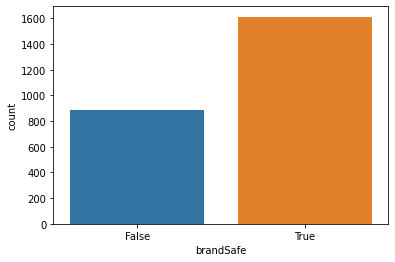

In [11]:
sns.countplot(df2.brandSafe)
plt.xlabel('brandSafe');

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


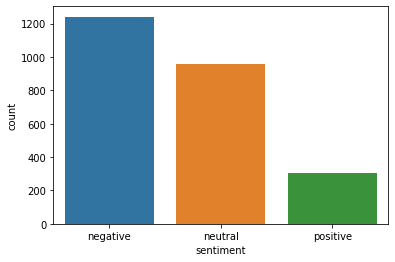

In [12]:
sns.countplot(df2.sentiment)
plt.xlabel('sentiment');

We select the Brand Safe, neutral and positive entities.

In [38]:
dff = df2[(df2['sentiment']=='neutral') | (df2['sentiment']=='positive') & (df2['brandSafe']==True)]

In [13]:
trending_entities.keys()

dict_keys(['person_list', 'loc_list', 'misc_list', 'org_list'])

Define data frames for each category of the trending set.

In [14]:
df_person = pd.json_normalize(trending_entities['person_list'])
df_misc = pd.json_normalize(trending_entities['misc_list'])
df_loc =  pd.json_normalize(trending_entities['loc_list'])
df_org = pd.json_normalize(trending_entities['org_list'])

Create data frame with entity data.

In [18]:
entities = df2['entities']
df_ents = pd.DataFrame()
for ent in entities:
  d = pd.DataFrame(eval(ent))
  df_ents = df_ents.append(d, ignore_index=True)
df_ents.head()  

,name,type
0,Λευκορωσια,LOC
1,Ηλιανα,PERSON
2,Χριστοπουλου,PERSON
3,Καλλιτση,PERSON
4,Ηλιανα Παπαγεωργιου,PERSON


Create a dictionary which matches the names with the times they appear.

In [19]:
names = list(df_ents['name'].unique())
dictionary = {}

for name in names:
  count = df_ents['name'].value_counts()[name]
  dictionary[name] = count

In [20]:
dictionary.keys()

dict_keys(['Λευκορωσια', 'Ηλιανα', 'Χριστοπουλου', 'Καλλιτση', 'Ηλιανα Παπαγεωργιου', 'Πατρα', 'Πανος', 'Θανος Πλευρης', 'Παπαγεωργιου', 'Βρετανια', 'Ελενας Χριστοπουλου', 'Καλλιτσης', 'Ηλιανας', 'Ρωσια', 'Πανου Καλλιτση', 'GNTM', 'Θριασιο', 'Ελενα', 'Ευρωπαικη Τραπεζα Ανασυγκροτησης', 'dailymedia.gr', 'Κυπελλου Ελλαδας', 'Λευκορωσος', 'Μιλωνα', 'Onsports.gr', 'Γιωργος Πετρεας', 'Κυπελλο', 'κορονοιο', 'ΠΑΟΚ', 'Λιγκ Καπ', 'Παλατακι', 'Ουντρις', 'Τουρκιας', 'Ουκρανια', 'Metropolis 95', 'Πετρεας', 'Γεωργιας', 'Ολυμπιακο', 'Αρτουρ Ουντρις', 'Ελληνες', 'Φοινικα Συρου', 'Ελλαδα', 'Λουκασενκο', 'Πλευρης', 'Ζ. Ραπτη', 'Δ. Αντωνιου', 'Google News', 'Πρωτοβαθμια Φροντιδα Υγειας', 'Γ. Κωτσηρας', 'ΑΠΕ-ΜΠΕ', 'Αγιου Ορους', 'Ταμειο Ανακαμψης', 'Γενικου Νοσοκομειου Ελευσινας', 'Εθνικο Συστημα Υγειας', 'Μεγαρων', 'Ενοπλων Δυναμεων', 'Σαλαμινος Κωνσταντινο', 'Βουλης των Ελληνων', 'Μαρτινου', 'Χ. Ροιλος', 'Αθ. Μαρτινος', '2ης ΥΠΕ', 'Παναγιας της Πορταιτισσας', 'Μ. Γκαγκα', 'ΕΣΥ', 'ΓΝΕ Θριασιο', 'Αντωνιο

In [21]:
df_trends = pd.DataFrame()
df_trends = df_person.append(df_misc).append(df_loc).append(df_org)
df_trends.head()

,entity,type,count,frequency
0,Ρουλα Πισπιριγκου,PERSON,4783977,455
1,Μανος Δασκαλακης,PERSON,3211292,263
2,Τζωρτζινας,PERSON,2807910,254
3,Αγγελικη Νικολουλη,PERSON,954515,45
4,Μαλενας,PERSON,832803,78


# Thank you in advance